## Подготовка

Загрузка библиотек и первый взгляд на данные

In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stop_words = stopwords.words('english')

pd.set_option('display.max_colwidth', 1000)

In [ ]:
df = pd.read_csv('toxic_comments.csv')
df.info()

In [ ]:
display(df.head())

In [ ]:
print(f"Количество дубликатов: {df.duplicated().sum()}")

In [ ]:
print(f"Баланс классов:", df['toxic'].value_counts())

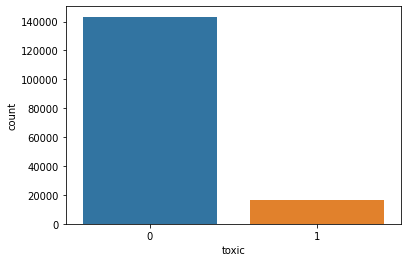

In [ ]:
sns.countplot(x = 'toxic', data = df)

Напишем класс реализующий все этапы предобработки и классификацию комментариев

In [ ]:
class WikiCL():

# Инициализируем классификацию комментариев

    def __init__(self,
                 models_and_params: list,
                 score: str,
                 solvers: list,
                 stop_words,
                 start_frame,
                 target_column,
                 data_column):
      
        # Запуск передаваемых параметров
        self.models_and_params = models_and_params
        self.score = score
        self.solvers = solvers
        self.stop_words = stop_words
        self.start_frame = start_frame
        self.target_column = target_column
        self.data_column = data_column
        self.lemm_corpus = None
        self.splited_data = None
        self.vect = None
        self.max_score = -1
        self.best_model = None

        # Функция разделяет датафрейм на три выборки: тренировочную, валидационную и тестовую
    def spl(self):

        presplited_data = train_test_split(self.lemm_corpus,
                                           self.start_frame[self.target_column],
                                           test_size = 0.2,random_state = 42)
        
        splited_data_w_val = train_test_split(presplited_data[1],
                                              presplited_data[3],
                                              test_size = 0.5,random_state = 42)
        
        self.splited_data = [presplited_data[0],
                             splited_data_w_val[0],
                             splited_data_w_val[1],
                             presplited_data[2],
                             splited_data_w_val[2],
                             splited_data_w_val[3]]

    # Лемматизация слов корпуса
    def lemm(self):
        # Инициализация лемматизатора
        lemmatizer = WordNetLemmatizer()
         # Лемматизация корпуса
        self.lemm_corpus = self.corpus.apply(lambda sentence: " ".join([lemmatizer.lemmatize(w,"n") for w in nltk.word_tokenize(sentence)]))

    # Очистка слов корпуса от лишних символов    
    def corp_cl(self):
         # Выделение корпуса для дальнейшего анализа
        corpus = self.start_frame[self.data_column]
        # Очистка корпуса от лишних символов
        self.corpus = corpus.apply(lambda sentence: re.sub(r'[^a-zA-Z]',' ',sentence))

     # Векторизация слов корпуса   
    def vector_list(self):
        # Создание словаря со словарями, которые хранят в себе векторизованные данные от разных векторизаторов 
        self.vect = {str(i()):{} for i in self.solvers}
        # Векторизация данных разными методами
        for vectorizer in self.solvers:
            # Инициализация векторизатора и установка стоп-слов
            vector = vectorizer(stop_words = self.stop_words)
            # Обучение и трансформация на обучающей выборке
            self.vect[str(vectorizer())]['train_data'] = vector.fit_transform(self.splited_data[0])
            self.vect[str(vectorizer())]['train_target'] = self.splited_data[3]
            # Трансформация тестовой выборки
            self.vect[str(vectorizer())]['test_data'] = vector.transform(self.splited_data[1])
            self.vect[str(vectorizer())]['test_target'] = self.splited_data[4]
            # Трансформация валидационной выборки
            self.vect[str(vectorizer())]['valid_data'] = vector.transform(self.splited_data[2])
            self.vect[str(vectorizer())]['valid_target'] = self.splited_data[5]
            
    # Инициализируем предобработку данных и после тренируем на них все переданные модели
    def fit(self):
      # Инициализация предобработки 
        self.corp_cl()
        print("Step one done")
        self.lemm()
        print("Two step done")
        self.spl()
        print("Three step done")
        self.vector_list()
        print("Four step done")

        # Инициализация словаря
        self.result = {str(name):{} for name,_ in self.models_and_params}
        print("Model training and search for maximum score started")
        # Перебор всех моделей
        for model, params in tqdm(self.models_and_params):
            # Перебор всех векторизаторов
            for vectorizer, data in tqdm(self.vect.items(),desc = str(model)):
                # Инициализация внутреннего словаря
                self.result[str(model)][str(vectorizer)] = {}
                # Инициализация грида
                self.result[str(model)][str(vectorizer)]["grid_object"] = GridSearchCV(model,params,cv = 3,scoring=self.score)
                # Тренировка грида
                self.result[str(model)][str(vectorizer)]["grid_object"].fit(self.vect[str(vectorizer)]['train_data'],
                                                                            self.vect[str(vectorizer)]['train_target'])
                # Сохранение лучшей модели
                self.result[str(model)][str(vectorizer)]["best_model"] = self.result[str(model)][str(vectorizer)]["grid_object"].best_estimator_
                # Сохранение лучшего скора на разных выборках
                self.result[str(model)][str(vectorizer)]["best_score_train"] = self.result[str(model)][str(vectorizer)]["grid_object"].best_score_
                self.result[str(model)][str(vectorizer)]["best_score_valid"] = f1_score(self.vect[str(vectorizer)]['valid_target'],
                                                                                        self.result[str(model)][str(vectorizer)]["best_model"].predict(self.vect[str(vectorizer)]['valid_data']))
                
                self.result[str(model)][str(vectorizer)]["best_score_test"] = f1_score(self.vect[str(vectorizer)]['test_target'],
                                                                                       self.result[str(model)][str(vectorizer)]["best_model"].predict(self.vect[str(vectorizer)]['test_data']))
                # Поиск максимального скора на валидационной выборке
                if self.result[str(model)][str(vectorizer)]["best_score_valid"] > self.max_score:
                    self.max_score = self.result[str(model)][str(vectorizer)]["best_score_test"]
                    self.best_model = self.result[str(model)][str(vectorizer)]["best_model"]
                    
        return {"max_score":self.max_score,"best_model":self.best_model}
    # Функцией выведем результаты обучения
    def get_info(self):
        print("Finish result")
        return self.results_1


Вывод

При подготовке данных для обучения самое важное это предобработка. Чтобы модель хорошо обучилась мы создали кластер функций внутри класса.

- Заложили необходимые параметры которые понадобяться при вычислении и выводе результатов.
- Добавили функцию, которая делит на выборки датафрейм.
- Написали функцию лемматизации комментариев и добавили корпус для очистки от мусора.
- Без векторов мы не сможем обучить модель, поэтому добавили функцию векторизации и создали словарь под это.
- Так же дали возможность обучаться моделям на выборке с перебором всех векторов
- Натренировали Гридсёрч
- И далее, так как нам нужны лучшие результаты и модель – сохранили их в переменной
- Теперь осталось только включить и увидим результат


## Обучение

Обозначим наши параметры для моделей

In [ ]:
reg_parameters = {"max_iter":[1000,2000,100], "C":[1.0,0.10,0.01]}
forest_parameters = {"n_estimators":[40,200,20],"max_depth":[2,10]}

Запустим процесс и обучим Логистическую регрессию и Случайный лес

In [ ]:
class_ = WikiCL([(LogisticRegression(random_state = 42,class_weight='balanced',n_jobs = -1),reg_parameters),
                 (RandomForestClassifier(random_state = 42,class_weight='balanced',n_jobs = -1),forest_parameters)],
                'f1',[TfidfVectorizer,CountVectorizer],stop_words,df,'toxic',"text")

In [ ]:
class_.fit()

Вывод

На выходе получили лучшую модель, это Логистическая регрессия с результатом F1 - 0.758

## Выводы

In [ ]:
report = pd.DataFrame(columns = ["Value"],
                      index = ["Best model",
                               "Best score"])


report.iloc[0] = ["LogisticRegression"]
report.iloc[1] = [0.75889]
display(report)

В ходе работы над проектом было сделано:

- Подготовленны данные обучения на моделях.
- Поделены данные на обучающую, валидационную и тестовою выборку.
- Обучены модели и выбраны лучшие из них на валидационной выборке.
- Подобраны параметры качества моделей.

Мы комплексно подошли к решению проблемы «Викишоп» и нам удалось создать решающий класс под задачу заказчика.

Как видно из таблицы, модель LogisticRegression с F1_score - 0.758 показала лучший результат.
